In [6]:
import edlib
import numpy as np
import heapq
import time
from Bio.Seq import Seq
import copy
import matplotlib.pyplot as plt
def rc(seq):
    return str(Seq(seq).reverse_complement())
def calculate_distance(ref, query, ref_st, ref_en, query_st, query_en):
    A = ref[ref_st: ref_en]
    a = query[query_st: query_en]
    # _a = rc(query[query_st: query_en])
    # return min(edlib.align(A, a)['editDistance'], edlib.align(A, _a)['editDistance'])
    return edlib.align(A, a)['editDistance']

def calculate_value(points, ref, query,penalty):  
    try:
        editdistance = 0
        aligned = 0
        preend = 0
        for onetuple in points:
            query_st, query_en, ref_st, ref_en = onetuple[0], onetuple[1], onetuple[2], onetuple[3]
            if(preend > query_st):#检测重叠
                return 0
            preend = query_en
            editdistance += calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)
            aligned += query_en - query_st
        return aligned - editdistance - len(points) * penalty #额外的惩罚碎片化的输出
    except:
        return 0

In [7]:
def simulated_annealing(origin,update,scoring,t0,kt=0.97,round=20,printf=False):
    score=scoring(origin)
    data=origin

    final=data
    final_score=score
    while(t0>=1):
        for i in range(round):
            nxt_data=update(data,t0)
            nxt_score=scoring(nxt_data)

            delta=nxt_score-score
            if(np.exp(delta/t0)>np.random.rand()):
                data=nxt_data
                score=nxt_score
                if(printf):print(data,score)
                if(score>final_score):
                    final,final_score=data,score
        data=final
        score=final_score
        t0*=kt
        if(printf):print(t0)
    return final,final_score

In [8]:
class PhaseMatch:
    def __init__(self,l,r,ml):
        self.l=l
        self.r=r
        self.scorelist=ml

def printPhaseMatch(l,topk):
    for i in l:
        for j in range(len(i.scorelist)):
            color=1/topk*j
            if(i.scorelist[j][1]>i.scorelist[j][2]):color=(0,0,1-color)
            else:color=(1-color,0,0)
            plt.plot((i.l,i.r),(i.scorelist[j][1],i.scorelist[j][2]),color=color)
    plt.show()

In [9]:
import tqdm
def DNA_match(reference,sample,seglen,penalty,topk):
	match_list:list[PhaseMatch]=[]
	pbar=tqdm.tqdm(total=len(sample))
	for i in range(0,len(sample),seglen):
		ri=min(i+seglen,len(sample))
		scorelist=[]
		for j in range(0,len(reference),seglen):
			rj=min(j+seglen,len(reference))
			scorelist.append((ri-i-edlib.align(reference[j:rj],sample[i:ri])['editDistance'],j,rj))
		scorelist=heapq.nlargest(topk,scorelist)

		for j in range(len(scorelist)):

			origin=[[i,ri,scorelist[j][1],scorelist[j][2]]]
			def update(data,t0):
				dv=max(int(t0),5)
				newdata=copy.deepcopy(data)
				newdata[0][2]+=np.random.randint(-dv,dv)
				newdata[0][2]=np.clip(newdata[0][2],0,len(reference))
				newdata[0][3]+=np.random.randint(-dv,dv)
				newdata[0][3]=np.clip(newdata[0][3],0,len(reference))
				return newdata
			def scoring(data):
				return calculate_value(data,reference,sample,penalty)
			data,score=simulated_annealing(origin,update,scoring,10,0.97,5)
			scorelist[j]=(score,data[0][2],data[0][3])
		
		scorelist=heapq.nlargest(topk,scorelist)
		if(len(scorelist)>0):
			match_list.append(PhaseMatch(i,ri,scorelist))
		pbar.update(seglen)
	pbar.close()

	tag=[1]*len(match_list)

	while True:
		mergel=0
		new_match_list=[]
		new_tag=[]
		drop_out=False
		with tqdm.tqdm(total=len(match_list)) as pbar:
			while(mergel<len(match_list)):
				if(mergel==len(match_list)-1):
					new_match_list.append(match_list[mergel])
					new_tag.append(0)
					break
				
				if tag[mergel]==0:
					new_match_list.append(match_list[mergel])
					new_tag.append(0)
					mergel+=1
					pbar.update(1)
					continue

				if mergel+1<len(match_list) and tag[mergel+1]==1:
					if np.random.rand()>0.8:
						new_match_list.append(match_list[mergel])
						new_tag.append(1)
						mergel+=1
						pbar.update(1)
						drop_out=True
						continue

				l=match_list[mergel].l
				r=match_list[mergel+1].r
				lenl=match_list[mergel].r-match_list[mergel].l
				lenr=match_list[mergel+1].r-match_list[mergel+1].l
				scorelist=[]
				scorebound=match_list[mergel].scorelist[0][0]+match_list[mergel+1].scorelist[0][0]
				def merge(refl,refr):
					origin=[[l,r,refl,refr]]
					def update(data,t0):
						dv=max(int(t0),10)
						newdata=copy.deepcopy(data)
						newdata[0][2]+=np.random.randint(-dv,dv)
						newdata[0][2]=np.clip(newdata[0][2],0,len(reference))
						newdata[0][3]+=np.random.randint(-dv,dv)
						newdata[0][3]=np.clip(newdata[0][3],0,len(reference))
						return newdata
					def scoring(data):
						return calculate_value(data,reference,sample,penalty)
					data,score=simulated_annealing(origin,update,scoring,max((r-l)//50,5),0.96,10)

					def IoU(l1,r1,l2,r2):
						d1=max(r1-l1,0)
						d2=max(r2-l2,0)
						d3=max(min(r1,r2)-max(l1,l2),0)
						if(d3>(d1+d2-d3)*0.9):return False
						else:return True
					flag=True
					for i in scorelist:
						if not IoU(i[1],i[2],data[0][2],data[0][3]):
							flag=False
							break
					if flag:
						scorelist.append((score,data[0][2],data[0][3]))
					
				for j in match_list[mergel].scorelist:
					merge(j[1],min(j[2]+lenr,len(reference)))
				for j in match_list[mergel+1].scorelist:
					merge(max(j[1]-lenl,0),j[2])
				
				scorelist=heapq.nlargest(topk,scorelist)
				if(scorelist[0][0]>scorebound):
					new_match_list.append(PhaseMatch(l,r,scorelist))
					new_tag.append(1)
					pbar.update(2)
					mergel+=2
				else:
					new_match_list.append(match_list[mergel])
					new_tag.append(0)
					pbar.update(1)
					mergel+=1
		if(len(new_match_list)<len(match_list) or drop_out):
			match_list=new_match_list
			tag=new_tag
			print("segment count: ",len(match_list))
		else:
			break
	return match_list 

145100it [04:41, 514.85it/s]                            
100%|█████████▉| 1450/1451 [03:37<00:00,  6.68it/s]


segment count:  806


100%|█████████▉| 805/806 [02:45<00:00,  4.86it/s]


segment count:  454


100%|█████████▉| 453/454 [02:35<00:00,  2.91it/s]


segment count:  250


100%|██████████| 250/250 [02:35<00:00,  1.61it/s]


segment count:  138


100%|██████████| 138/138 [03:09<00:00,  1.37s/it]


segment count:  75


 99%|█████████▊| 74/75 [04:15<00:03,  3.45s/it]


segment count:  41


100%|██████████| 41/41 [05:55<00:00,  8.67s/it]


segment count:  24


 96%|█████████▌| 23/24 [07:50<00:20, 20.44s/it]


segment count:  16


100%|██████████| 16/16 [18:48<00:00, 70.51s/it] 


segment count:  13


 92%|█████████▏| 12/13 [03:52<00:19, 19.41s/it]


segment count:  13


 92%|█████████▏| 12/13 [17:21<01:26, 86.78s/it]


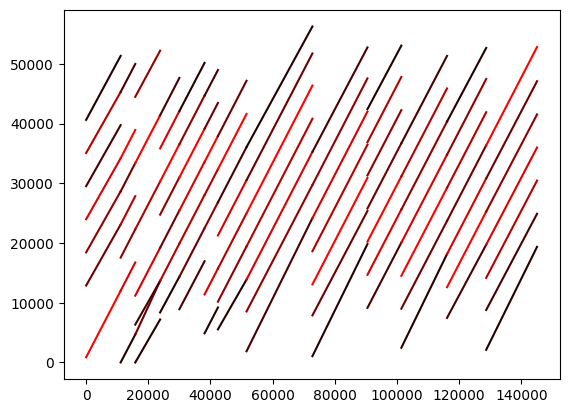

In [10]:
with open("reference.txt",'r') as file:
    reference=file.read()
with open("sample.txt",'r') as file:
    sample=file.read()

topk=7

match_list=DNA_match(reference,sample,100,30,topk)
printPhaseMatch(match_list,topk)

In [11]:
origin=[[],[]]
for i in match_list:
    origin[0].append([i.l,i.r])
    origin[1].append([i.scorelist[0][1],i.scorelist[0][2]])

def trans(data):
    l=[]
    for i in range(len(data[0])):
        l.append((data[0][i][0],data[0][i][1],data[1][i][0],data[1][i][1]))
    return l
print(origin)
print(trans(origin))
print(calculate_value(trans(origin),reference,sample,30))


[[[0, 11100], [11100, 15800], [15800, 23800], [23800, 30000], [30000, 38100], [38100, 42400], [42400, 51600], [51600, 72800], [72800, 90500], [90500, 101400], [101400, 116100], [116100, 128700], [128700, 145063]], [[870, 12001], [34192, 38929], [33382, 41389], [30297, 36547], [30998, 39133], [33586, 37910], [32363, 41614], [24977, 46357], [13076, 30915], [20231, 31149], [14505, 29241], [12599, 25266], [36359, 52813]]]
[(0, 11100, 870, 12001), (11100, 15800, 34192, 38929), (15800, 23800, 33382, 41389), (23800, 30000, 30297, 36547), (30000, 38100, 30998, 39133), (38100, 42400, 33586, 37910), (42400, 51600, 32363, 41614), (51600, 72800, 24977, 46357), (72800, 90500, 13076, 30915), (90500, 101400, 20231, 31149), (101400, 116100, 14505, 29241), (116100, 128700, 12599, 25266), (128700, 145063, 36359, 52813)]
139289


In [ ]:
import numpy as np
def trans(data):
    l=[]
    for i in range(len(data[0])):
        l.append((data[0][i][0],data[0][i][1],data[1][i][0],data[1][i][1]))
    return l

def scoring(data):
    return calculate_value(trans(data),reference,sample,30)

for round in range(100):
    l=round%(len(origin[0])-1)
    origin1=[
        [origin[0][l][0],origin[0][l][1],origin[0][l+1][1]],
        [[origin[1][l][0],origin[1][l][1]],[origin[1][l+1][0],origin[1][l+1][1]]]
    ]
    saml=0 if l==0 else origin[0][l-1][1]
    samr=len(sample) if l+1==len(origin[0])-1 else origin[0][l+2][0]

    def update1(data,t0):
        newdata=copy.deepcopy(data)
        dv=max(int(t0),1)
        for i in range(len(data[0])):
            newdata[0][i]=np.clip(data[0][i]+np.random.randint(-dv,dv),saml,samr)
        newdata[0].sort()

        for i in range(len(data[1])):
            def update1(data,t0):
                dv=max(int(t0),10)
                newdata:list=copy.deepcopy(data)
                newdata[0]=newdata[0]+np.random.randint(-dv,dv)
                newdata[0]=np.clip(newdata[0],0,len(reference))
                newdata[1]=newdata[1]+np.random.randint(-dv,dv)
                newdata[1]=np.clip(newdata[1],0,len(reference))
                newdata.sort()
                return newdata
            def scoring1(data1):
                return calculate_value([(newdata[0][i],newdata[0][i+1],data1[0],data1[1])],reference,sample,30)
            
            newdata[1][i],score=simulated_annealing(data[1][i],update1,scoring1,t0,0.96,10)
        return newdata
    
    def trans1(data):
        l=[]
        for i in range(len(data[1])):
            l.append((data[0][i],data[0][i+1],data[1][i][0],data[1][i][1]))
        return l

    def scoring1(data):
        return calculate_value(trans1(data),reference,sample,30)
    
    data1,score=simulated_annealing(origin1,update1,scoring1,2000,0.96,10)
    origin[0][l],origin[0][l+1]=(data1[0][0],data1[0][1]),(data1[0][1],data1[0][2])
    origin[1][l],origin[1][l+1]=data1[1][0],data1[1][1]
    print(round,scoring(origin),trans(origin),sep=" ")


print(trans(origin))
print(scoring(origin))    

0 139291 [(0, 11599, 870, 12504), (11599, 15800, 34691, 38929), (15800, 23800, 33382, 41389), (23800, 30000, 30297, 36547), (30000, 38100, 30998, 39133), (38100, 42400, 33586, 37910), (42400, 51600, 32363, 41614), (51600, 72800, 24977, 46357), (72800, 90500, 13076, 30915), (90500, 101400, 20231, 31149), (101400, 116100, 14505, 29241), (116100, 128700, 12599, 25266), (128700, 145063, 36359, 52813)]
1 139292 [(0, 11599, 870, 12504), (11599, 15100, 34691, 38220), (15100, 23800, 32675, 41389), (23800, 30000, 30297, 36547), (30000, 38100, 30998, 39133), (38100, 42400, 33586, 37910), (42400, 51600, 32363, 41614), (51600, 72800, 24977, 46357), (72800, 90500, 13076, 30915), (90500, 101400, 20231, 31149), (101400, 116100, 14505, 29241), (116100, 128700, 12599, 25266), (128700, 145063, 36359, 52813)]
2 139299 [(0, 11599, 870, 12504), (11599, 15100, 34691, 38220), (15100, 24588, 32675, 42167), (24588, 30000, 31081, 36547), (30000, 38100, 30998, 39133), (38100, 42400, 33586, 37910), (42400, 51600,